Victor Fleiser (28706870)

Frédéric Li Combeau (21400017)

Thomas Marchand (21113482)

# Notebook d'Analyse

### Imports et definitions de fonctions/données utilisées par la suite

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

%matplotlib inline

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- CONFIGURATION ---
LOGS_PATH = "logs"
LOG_FILE = "logs.csv"
PLOTS_DIR = "plots"
TOTAL_POSTS = 11

# Ensure output directory exists
os.makedirs(PLOTS_DIR, exist_ok=True)

# Map long URLs to short titles for graphs
POST_MAP = {
    "philosophie": "Vie", "thibaultbrock": "Sonic", "robot_cuiseur": "Cuiseur",
    "deformation": "Déform.", "hobby": "Hobby", "metier_indispensable": "Métier",
    "vendeur": "Vol", "roquefort": "Roq.", "sauvegarde": "PS1",
    "trophees": "Troph.", "30kmh": "Lyon"
}

def get_short_name(url):
    for k, v in POST_MAP.items():
        if k in str(url): return v
    return "Post"

# Helper for statistical brackets
def draw_bracket(ax, x1, x2, y, p):
    h, col = 2, 'k'
    text = "***" if p < .001 else "**" if p < .01 else "*" if p < .05 else f"ns (p={p:.2f})"
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    ax.text((x1+x2)*.5, y+h, text, ha='center', va='bottom', color=col)

print("Configuration loaded.")

Configuration loaded.


In [7]:
def load_data():
    path = os.path.join(LOGS_PATH, LOG_FILE)
    if not os.path.exists(path): 
        print(f"Error: {path} not found.")
        return pd.DataFrame()
    
    df = pd.read_csv(path)
    
    # 1. Type Conversion
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    df = df.dropna(subset=['timestamp']).sort_values('timestamp')
    
    # 2. Deduplication (Technical logs)
    df = df.drop_duplicates(subset=['session_id', 'trial_id', 'event_type'], keep='last')
    
    # 3. Logic: AI Correctness & Probabilities
    df['ai_prob'] = pd.to_numeric(df['ai_output_probability'], errors='coerce')
    is_ai = df['ai_generated_post'].astype(str).str.lower() == 'true'
    ai_yes = df['ai_prob'] > 0.5
    
    # AI is correct if: (It is AI AND it says Yes) OR (It is Human AND it says No)
    df['ai_correct'] = ((is_ai & ai_yes) | (~is_ai & ~ai_yes)).astype(int)
    
    # 4. Labeling
    df['post_short'] = df['post'].apply(get_short_name)
    df['cond_label'] = df['condition'].apply(lambda x: 'Human + AI' if 'AI' in str(x) else 'Human Only')
    
    return df

# Execute Load
df = load_data()

if not df.empty:
    print(f"Data loaded successfully: {len(df)} rows.")
    display(df.head(3)) # Pandas nice display
else:
    print("No data found.")

Data loaded successfully: 535 rows.


,timestamp,event_type,session_id,trial_id,post,condition,model_used,ai_generated_post,user_confidence,user_decision,...,ai_output_response,ai_output_conclusion,ai_uncertainty,extracted_text,capture_name,notes,ai_prob,ai_correct,post_short,cond_label
9,2026-01-18 19:47:26.672000+00:00,post_edited,facf3a21-00ca-4043-8cdb-64591d2c0783,NaN,https://x.com/thibaultbrock/status/12260804742...,User + AI,NaN,True,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,Sonic,Human + AI
10,2026-01-18 19:48:50.303000+00:00,start,facf3a21-00ca-4043-8cdb-64591d2c0783,0.0,https://www.reddit.com/r/france/comments/tw35n...,User + AI,gemma3,False,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Cuiseur,Human + AI
11,2026-01-18 19:49:24.011000+00:00,manual_text_edit,facf3a21-00ca-4043-8cdb-64591d2c0783,0.0,https://www.reddit.com/r/france/comments/tw35n...,User + AI,gemma3,False,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Cuiseur,Human + AI



========== H1: PERFORMANCE ==========
Means -> Human: 45.5% | Team: 55.8% | AI: 27.5%
T-Test (Human vs Team): p=0.1639


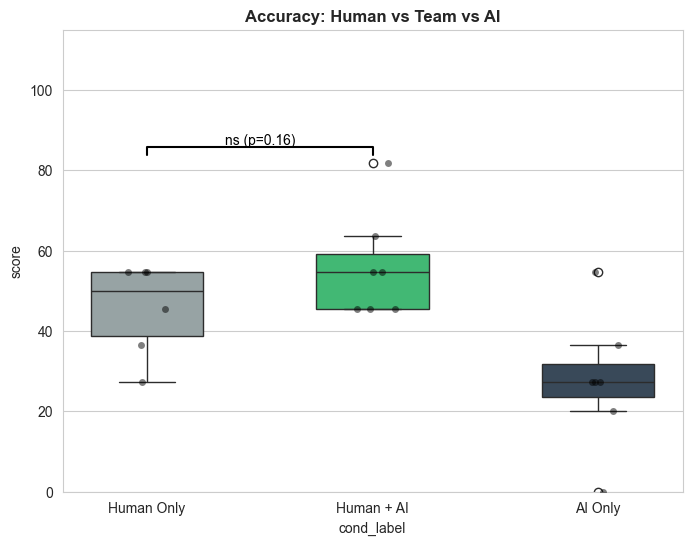

In [8]:
def plot_performance(df):
    print(f"\n{'='*10} H1: PERFORMANCE {'='*10}")
    
    # 1. Prepare Human Data
    dec = df[df['event_type'] == 'decision'].copy()
    dec['score'] = (dec['correct'] == 'YES').astype(int) * 100
    h_stats = dec.groupby(['session_id', 'cond_label'])['score'].mean().reset_index()
    
    # 2. Prepare AI Data
    ai = df[df['event_type'] == 'evaluation_ended'].dropna(subset=['ai_correct'])
    ai_stats = ai.groupby('session_id')['ai_correct'].mean().reset_index()
    ai_stats['score'] = ai_stats['ai_correct'] * 100
    ai_stats['cond_label'] = 'AI Only'
    
    # 3. Combine
    plot_df = pd.concat([h_stats, ai_stats], ignore_index=True)
    
    # 4. Stats Calculation
    h_only = h_stats[h_stats['cond_label'] == 'Human Only']['score']
    h_ai = h_stats[h_stats['cond_label'] == 'Human + AI']['score']
    
    # T-Test
    p_val = 1.0
    if len(h_only) > 1 and len(h_ai) > 1:
        p_val = stats.ttest_ind(h_ai, h_only)[1]
    
    print(f"Means -> Human: {h_only.mean():.1f}% | Team: {h_ai.mean():.1f}% | AI: {ai_stats['score'].mean():.1f}%")
    print(f"T-Test (Human vs Team): p={p_val:.4f}")

    # 5. Plotting
    plt.figure(figsize=(8, 6))
    sns.set_style("whitegrid")
    
    # Updated Order
    order = ['Human Only', 'Human + AI', 'AI Only']
    colors = {'Human Only': '#95a5a6', 'Human + AI': '#2ecc71', 'AI Only': '#34495e'}
    
    ax = sns.boxplot(x='cond_label', y='score', data=plot_df, order=order, palette=colors, width=0.5)
    sns.stripplot(x='cond_label', y='score', data=plot_df, order=order, color='black', alpha=0.5, jitter=0.1)
    
    # Draw Significance
    if len(h_only) > 1:
        draw_bracket(ax, 0, 1, plot_df['score'].max() + 2, p_val)
    
    plt.ylim(0, 115)
    plt.title("Accuracy: Human vs Team vs AI", weight='bold')
    plt.savefig(os.path.join(PLOTS_DIR, "H1_Performance.png"), dpi=300, bbox_inches='tight')
    plt.show()

if not df.empty:
    plot_performance(df)


========== H3: TIME & UNCERTAINTY ==========
Avg Time -> High Unc: 57.65s | Low Unc: 54.80s
T-Test p-value: 0.8620


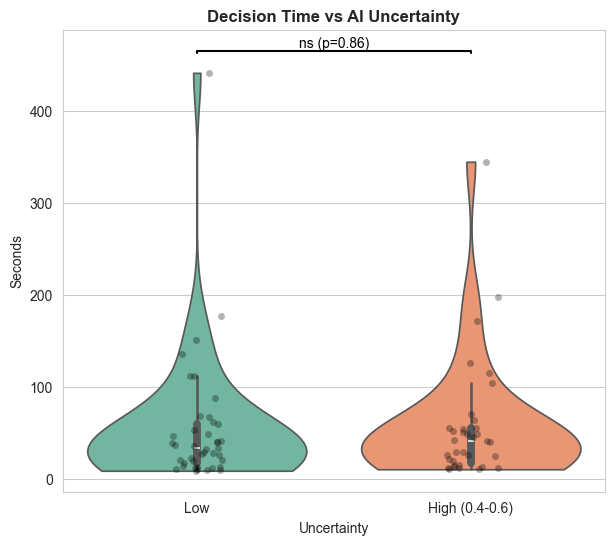

In [9]:
def plot_time_uncertainty(df):
    print(f"\n{'='*10} H3: TIME & UNCERTAINTY {'='*10}")
    
    # 1. Calculate Duration (Pivot start vs decision)
    times = df[df['event_type'].isin(['start', 'decision'])].pivot_table(
        index=['session_id', 'trial_id'], columns='event_type', values='timestamp', aggfunc='first'
    ).reset_index()
    
    if 'start' not in times or 'decision' not in times:
        print("Missing start/decision events, cannot calculate duration.")
        return

    times['dur'] = (times['decision'] - times['start']).dt.total_seconds()
    
    # 2. Merge with AI Probabilities
    probs = df[df['event_type'] == 'evaluation_ended'][['session_id', 'trial_id', 'ai_prob']]
    data = pd.merge(times, probs, on=['session_id', 'trial_id'])
    
    # 3. Categorize Uncertainty
    data['Uncertainty'] = np.where((data['ai_prob'] >= 0.4) & (data['ai_prob'] <= 0.6), 
                                   'High (0.4-0.6)', 'Low')
    
    # 4. Stats
    high = data[data['Uncertainty'].str.startswith('High')]['dur']
    low = data[data['Uncertainty'] == 'Low']['dur']
    
    p_val = 1.0
    if len(high) > 1 and len(low) > 1:
        p_val = stats.ttest_ind(high, low)[1]
        
    print(f"Avg Time -> High Unc: {high.mean():.2f}s | Low Unc: {low.mean():.2f}s")
    print(f"T-Test p-value: {p_val:.4f}")

    # 5. Violin Plot
    plt.figure(figsize=(7, 6))
    sns.set_style("whitegrid")
    
    ax = sns.violinplot(x='Uncertainty', y='dur', data=data, palette="Set2", inner="box", cut=0)
    sns.stripplot(x='Uncertainty', y='dur', data=data, color='k', alpha=0.3, jitter=0.1)
    
    if len(high) > 1:
        draw_bracket(ax, 0, 1, data['dur'].max() * 1.05, p_val)
    
    plt.ylabel("Seconds")
    plt.title("Decision Time vs AI Uncertainty", weight='bold')
    plt.savefig(os.path.join(PLOTS_DIR, "H3_Time.png"), dpi=300, bbox_inches='tight')
    plt.show()

if not df.empty:
    plot_time_uncertainty(df)

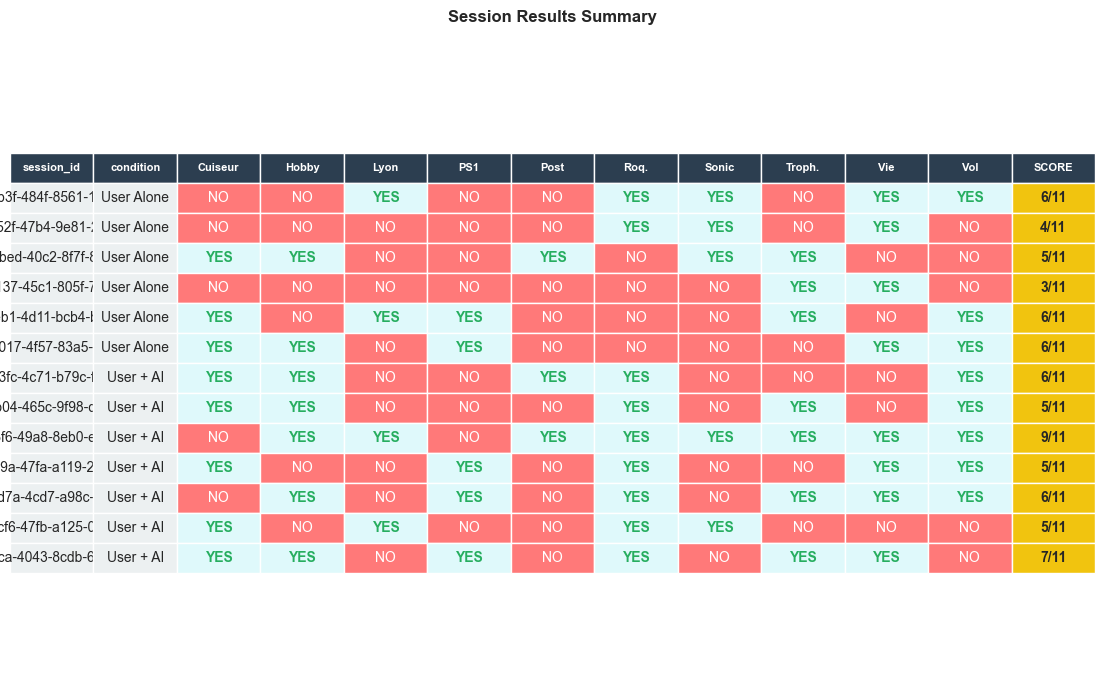

In [10]:
def plot_results_table(df):
    dec = df[df['event_type'] == 'decision']
    
    # 1. Create Matrix
    pivot = dec.pivot_table(index=['session_id', 'condition'], columns='post_short', 
                           values='correct', aggfunc='first').fillna('-')
    
    # 2. Calculate Total Score Column
    pivot['SCORE'] = dec.groupby(['session_id', 'condition'])['correct'].apply(
        lambda x: f"{sum(x=='YES')}/{TOTAL_POSTS}"
    )
    
    # 3. Sort: Condition descending (alphabetical) then session
    flat = pivot.reset_index().sort_values(by=['condition', 'session_id'], ascending=[False, True])
    
    # 4. Render Table
    fig, ax = plt.subplots(figsize=(14, len(flat) * 0.5 + 2))
    ax.axis('off')
    
    # Create table
    table = ax.table(cellText=[flat.columns] + flat.values.tolist(), 
                     loc='center', cellLoc='center', colLabels=None)
    
    # 5. Styling
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.8) # Adjust scale for row height
    
    for (row, col), cell in table.get_celld().items():
        cell.set_edgecolor('white')
        if row == 0: # Header
            cell.set_facecolor('#2c3e50')
            cell.set_text_props(color='white', weight='bold', size=8) # Small font for header
        else:
            val = cell.get_text().get_text()
            # Conditional Formatting
            if val == 'YES': 
                cell.set_facecolor('#dff9fb')
                cell.set_text_props(color='#27ae60', weight='bold')
            elif val == 'NO': 
                cell.set_facecolor('#ff7979')
                cell.set_text_props(color='white')
            elif col == len(flat.columns)-1: # Score Column
                cell.set_facecolor('#f1c40f')
                cell.set_text_props(weight='bold')
            else: 
                cell.set_facecolor('#ecf0f1')

    plt.title("Session Results Summary", weight='bold', pad=10)
    plt.savefig(os.path.join(PLOTS_DIR, "Table_Results.png"), dpi=300, bbox_inches='tight')
    plt.show()

if not df.empty:
    plot_results_table(df)

La performance Human + AI Performance est supérieure au maximum de la performance entre Human tout seul et AI tout seul.

TODO tester si la différence est significative